# Busting Triangle Inequality

The objective of this notebook is to demonstrate that the triangle inequality doesn't hold.

References:
- https://en.wikipedia.org/wiki/Information_geometry

# 0. Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

In [9]:
# %matplotlib widget
%matplotlib inline

# 1. Helper Functions

In [3]:
def gaussian(mu: float, sigma: float, x: np.array = None):
    if x==None:
        x = np.linspace(-50, 50, 5000)
    scaling_constant = (1 / (sigma * np.sqrt(2 * np.pi)))
    y = scaling_constant * np.e ** (-.5 * ((x - mu) / sigma) ** 2)
    return x, y

In [4]:
def plot_gaussian(mu: float, sigma: float):
    x, y = gaussian(mu=mu, sigma=sigma)
    plt.plot(x, y, label=f"mu={mu}, sigma={sigma}")
    plt.legend()
    plt.ylim((0, 1))

In [61]:
def gaussian_intersections(mu_1: float, sigma_1: float, mu_2: float, sigma_2: float, plot: bool = False):
    """https://stackoverflow.com/questions/22579434/python-finding-the-intersection-point-of-two-gaussian-curves"""
    a = 1/(2*sigma_1**2) - 1/(2*sigma_2**2)
    b = mu_2/(sigma_2**2) - mu_1/(sigma_1**2)
    c = mu_1**2 /(2*sigma_1**2) - mu_2**2 / (2*sigma_2**2) - np.log(sigma_2/sigma_1)
    return np.roots([a,b,c])

def gaussian_similarity(mu_1: float, sigma_1: float, mu_2: float, sigma_2: float, plot: bool = False) -> float:
    """
    Measures the shared area between two gaussians; returns a float in the range [0, 1]
    If mu_1=mu_2 and sigma_1=sigma_2, then similarity=1. If they are completely different, then similarity=0.
    """
    
    # the form of the solution changes depending on whether or not sigma_1 or sigma_2 is greater, so change
    # the variables to be sigma_greater and sigma_lesser
    if sigma_1 > sigma_2:
        sigma_g = sigma_1
        mu_g = mu_1
        sigma_l = sigma_2
        mu_l = mu_2
    else:
        sigma_l = sigma_1
        mu_l = mu_1
        sigma_g = sigma_2
        mu_g = mu_2
    del(mu_1, sigma_1, mu_2, sigma_2)
    
    # get the intersections of the two distributions
    intersections = list(sorted(gaussian_intersections(mu_1=mu_l, sigma_1=sigma_l, mu_2=mu_g, sigma_2=sigma_g)))
    
    # plot
    if plot:
        for mu, sigma in zip([mu_l, mu_g], [sigma_l, sigma_g]):
            x, y = gaussian(mu=mu, sigma=sigma)
            plt.plot(x, y, label=f"mu={mu}, sigma={sigma}")
        plt.legend()
        plt.ylim((0, 1))
        plt.xlim((-40, 40))
        for intersection in intersections:
            plt.axvline(x=intersection, color='red', linestyle='--')
        plt.xlim((min(mu_g, mu_l) - 4 * sigma_g, max(mu_g, mu_l) + 4 * sigma_g))
        plt.show()
    
    # if the standard deviations are equal, then there's only one intersection point.
    if sigma_l == sigma_g:
        if mu_l < mu_g:
            return 2 * st.norm(mu_g, sigma_g).cdf(intersections[0])
        elif mu_l == mu_g:
            return 1
        else:
            return 2 * st.norm(mu_l, sigma_l).cdf(intersections[0])
    
    # else there's three regions to consider
    else:

        # 
        f_g = st.norm(mu_g, sigma_g)
        f_l = st.norm(mu_l, sigma_l)
        return f_l.cdf(intersections[0]) - f_g.cdf(intersections[0]) + f_g.cdf(intersections[1]) + (1 - f_l.cdf(intersections[1]))
    
def gaussian_distance(mu_1: float, sigma_1: float, mu_2: float, sigma_2: float, plot=False) -> float:
    sim = gaussian_similarity(mu_1=mu_1,
                              sigma_1=sigma_1,
                              mu_2=mu_2,
                              sigma_2=sigma_2,
                              plot=plot)
    return (1 / sim) - 1

def gaussian_path_length(mu_list: list[float], sigma_list: list[float], plot: bool = False) -> float:
    if len(mu_list) != len(sigma_list):
        print("Need the same number of mu's as sigma's. Exiting.")
        return
    
    distance = 0
    for i in range(len(mu_list) - 1):
        distance += gaussian_distance(mu_list[i],
                                      sigma_list[i],
                                      mu_list[i + 1],
                                      sigma_list[i + 1],
                                      plot=plot)
    return distance

# 2. Demonstrating Different Gaussians

#### Different Gaussians doing different stuff

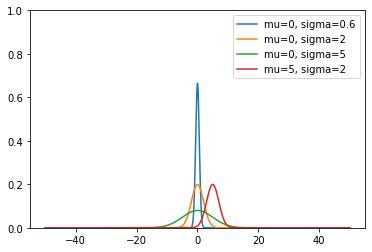

In [14]:
mu = 0
for mu, sigma in zip([0, 0, 0, 5], [.6, 2, 5, 2]):
    plot_gaussian(mu, sigma)
plt.show()

#### Distance function

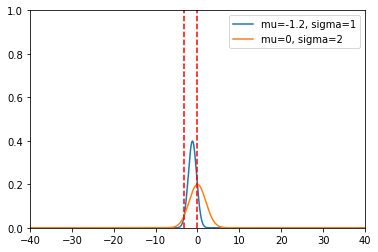

0.02, 0.43, 0.12
0.7287593452386079


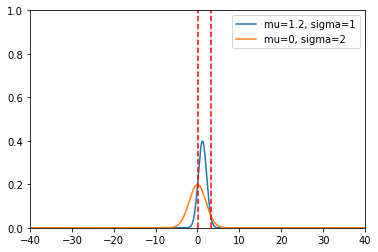

0.12, 0.49, 0.02
0.5667553242187984


In [15]:
print(gaussian_distance(mu_1=-1.2, sigma_1=1, mu_2=0, sigma_2=2, plot=True))
print(gaussian_distance(mu_1=1.2,  sigma_1=1, mu_2=0, sigma_2=2, plot=True))

# 3. Test the Space

There are three expected behaviors to test:
```
1. d((mu_a, sigma_a), (mu_a, sigma_a)) = 0
2. d((mu_a, sigma_inf), (mu_b, sigma_inf)) = 0 for all mu_a, mu_b
3. d((mu_a, sigma_0), (mu_b, sigma_0)) = inf for all mu_a, mu_b, where mu_a != mu_b
```

#### 1. `d((mu_a, sigma_a), (mu_a, sigma_a)) = 0`

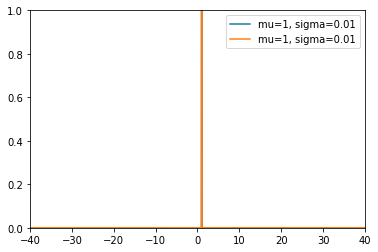

0.0


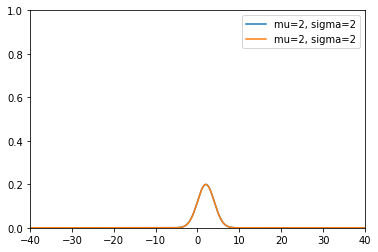

0.0


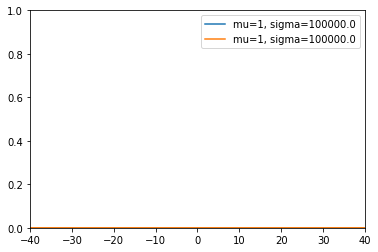

0.0


In [16]:
for mu_a, sigma_a in zip([1, 2, 1], [1e-2, 2, 1e5]):
    print(gaussian_distance(mu_1=mu_a,
                            sigma_1=sigma_a,
                            mu_2=mu_a,
                            sigma_2=sigma_a,
                            plot=True))

#### 2. `d((mu_a, sigma_inf), (mu_b, sigma_inf)) = 0 for all mu_a, mu_b`

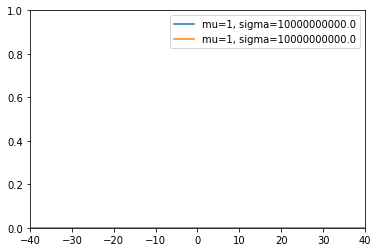

0.0


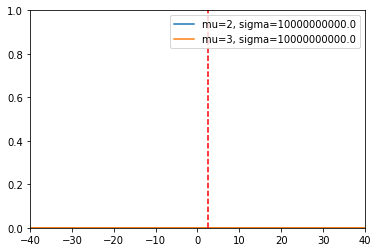

3.9894310077670525e-11


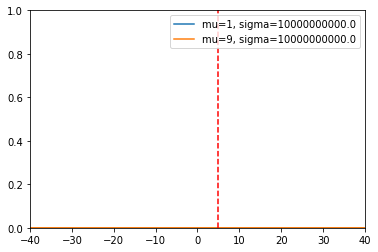

3.191538144875494e-10


In [17]:
sigma_inf = 1e10
for mu_a, mu_b in zip([1, 2, 1], [1, 3, 9]):
    print(gaussian_distance(mu_1=mu_a,
                            sigma_1=sigma_inf,
                            mu_2=mu_b,
                            sigma_2=sigma_inf,
                            plot=True))

#### 3. `d((mu_a, sigma_0), (mu_b, sigma_0)) = inf for all mu_a, mu_b, where mu_a != mu_b`

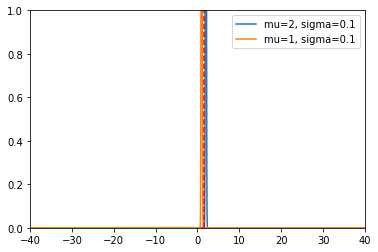

1744276.8936189488


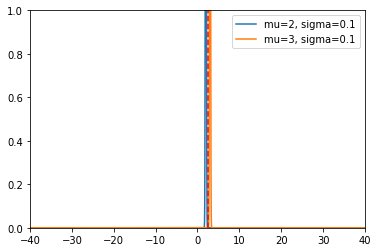

1744276.8936189488


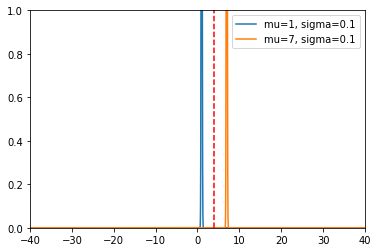

1.0190119241180861e+197


In [18]:
sigma_0 = 1e-1
for mu_a, mu_b in zip([2, 2, 1], [1, 3, 7]):
    print(gaussian_distance(mu_1=mu_a,
                            sigma_1=sigma_0,
                            mu_2=mu_b,
                            sigma_2=sigma_0,
                            plot=True))

# 3. What's the shortest mid_point?

In [54]:
# distance = gaussian_path_length([-1, 0, 1], [.5, 1, .5], plot=True)
# print(f"Distance is {distance:.4f}")

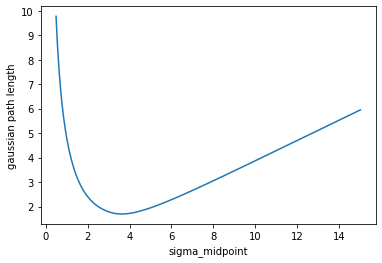

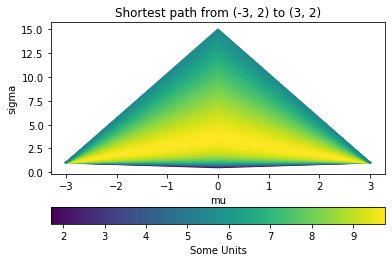

In [111]:
# https://stackoverflow.com/questions/38208700/matplotlib-plot-lines-with-colors-through-colormap
import pylab
import matplotlib as mpl

sigma_midpoints = np.linspace(.5, 15, 200)
mus = [-3, 0, 3]
sigma_start = 2
sigma_end = 2
gaussian_path_lengths = [gaussian_path_length(mus, [sigma_start, sigma_midpoint, sigma_end])
                         for sigma_midpoint in sigma_midpoints]
plt.plot(sigma_midpoints, gaussian_path_lengths)
plt.xlabel('sigma_midpoint')
plt.ylabel('gaussian path length')
plt.show()

fig, ax = plt.subplots()
for sigma_midpoint, path_length in zip(sigma_midpoints, gaussian_path_lengths):
    color_index = 255 - int(255 * (path_length - min(gaussian_path_lengths)) / (max(gaussian_path_lengths) - min(gaussian_path_lengths)))
    plt.plot([-3, 0, 3], [1, sigma_midpoint, 1], color=cm.colors[color_index])
plt.ylabel('sigma')
plt.xlabel('mu')
plt.title(f'Shortest path from {(mus[0], sigma_start)} to {(mus[2], sigma_end)}')

cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=min(gaussian_path_lengths), vmax=max(gaussian_path_lengths))
axcb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='horizontal', label='Some Units')
plt.show()